In [1]:
from utils.loadData import loadData, loadDataWithNews
from lstm.preprocessing import dataToTimeSeriesMultiDimensional, getDatasetsMultiDimensional, normalizeAtOnce
from lstm.model import getModel, evaluateModelQuick, evaluateFinal
from lstm.visualization import visualize_loss, show_batch, show_data_simple, showRegressionExampleMultiDimensional
from lstm.callbacks import es_callback, modelckpt_callback
from keras.utils.vis_utils import plot_model

In [2]:
df = loadDataWithNews()
df.head()

,Unnamed: 0,Date,Open,High,Low,Close,Adj Close,Volume,positive,neutral,negative
0,0,2020-12-17,21308.351563,23642.660156,21234.675781,22805.162109,22805.162109,71378606374,2,3,0
1,1,2020-12-18,22806.796875,23238.601563,22399.812500,23137.960938,23137.960938,40387896275,3,2,0
2,2,2020-12-19,23132.865234,24085.855469,22826.472656,23869.832031,23869.832031,38487546580,0,1,0
3,3,2020-12-20,23861.765625,24209.660156,23147.710938,23477.294922,23477.294922,37844228422,1,2,0
4,4,2020-12-21,23474.455078,24059.982422,22159.367188,22803.082031,22803.082031,45852713981,3,3,0


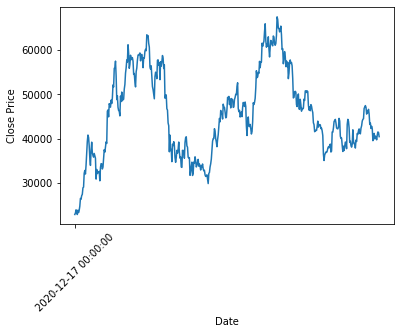

In [3]:
features = df.loc[:, df.columns != 'Date']
features = features.loc[:, features.columns != 'Unnamed: 0']
features = features.loc[:, features.columns != 'Adj Close']
# no news data here
features = features.iloc[:,:-3]
normalized_data, scaler = normalizeAtOnce(features)
show_data_simple(features["Close"], df["Date"])

In [4]:
print(normalized_data.shape)

(487, 5)


2022-06-05 11:48:34.973547: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


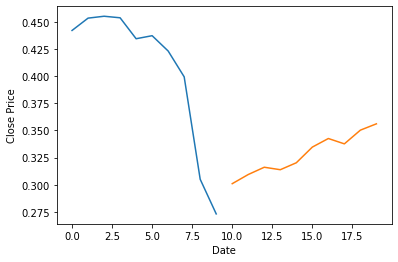

Input shape: (40, 10, 5)
Target shape: (40,)


In [5]:
config = {
    "past": 10,
    "future": 10,
    "neurons": 50,
    "batch_size": 128,
    "epochs": 50,
    "features": normalized_data.shape[1]
}

dataset_train, dataset_val, x_test, y_test = getDatasetsMultiDimensional(config, normalized_data)


for batch in dataset_val.take(1):
    inputs, targets = batch
    show_batch(inputs[0, :, 3], targets[:config["future"]], config["past"])

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

In [6]:
model = getModel(config)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 5)]           0         
                                                                 
 lstm (LSTM)                 (None, 10, 50)            11200     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 10)                510       
                                                                 
Total params: 31,910
Trainable params: 31,910
Non-trainable params: 0
_________________________________________________________________


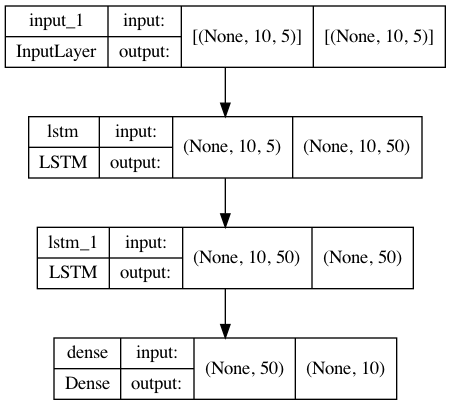

In [7]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Epoch 1/50
1/3 [=========>....................] - ETA: 7s - loss: 0.4095 - rmse: 0.6400 - mae: 0.5892 - mape: 105.2264
Epoch 1: val_loss improved from inf to 0.13853, saving model to checkpoints/model_checkpoint.h5
3/3 [==============================] - 5s 495ms/step - loss: 0.3555 - rmse: 0.5963 - mae: 0.5505 - mape: 101.7473 - val_loss: 0.1385 - val_rmse: 0.3722 - val_mae: 0.3646 - val_mape: 93.6064
Epoch 2/50
1/3 [=========>....................] - ETA: 0s - loss: 0.3384 - rmse: 0.5817 - mae: 0.5328 - mape: 94.5239
Epoch 2: val_loss improved from 0.13853 to 0.10763, saving model to checkpoints/model_checkpoint.h5
3/3 [==============================] - 0s 84ms/step - loss: 0.2901 - rmse: 0.5386 - mae: 0.4920 - mape: 90.2393 - val_loss: 0.1076 - val_rmse: 0.3281 - val_mae: 0.3144 - val_mape: 80.3926
Epoch 3/50
1/3 [=========>....................] - ETA: 0s - loss: 0.2729 - rmse: 0.5224 - mae: 0.4700 - mape: 82.6445
Epoch 3: val_loss improved from 0.10763 to 0.07840, saving model to che

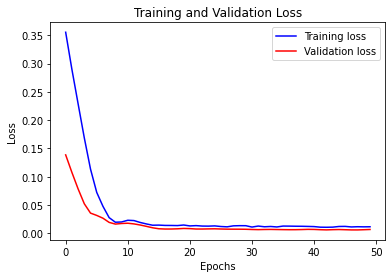

In [8]:
history = model.fit(
    dataset_train,
    epochs=config["epochs"],
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)
visualize_loss(history)

In [9]:
x, y = dataToTimeSeriesMultiDimensional(x_test, y_test[:,3], config["past"], config["future"])

In [10]:
evaluateModelQuick(model, x, y)

1/1 [==============================] - 1s 840ms/step - loss: 0.0079 - rmse: 0.0891 - mae: 0.0745 - mape: 16.7779
---- TEST RESULTS ----
MSE loss - 0.007941734977066517
RMSE - 0.0891164094209671


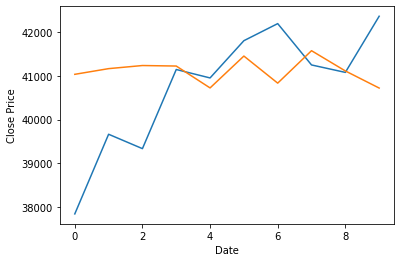

In [11]:
showRegressionExampleMultiDimensional(x[0], y[0], model, scaler)

In [12]:
evaluateFinal(getModel, dataset_train, dataset_val, x, y, config, "regression_with_rich_features_limited_news_data")

Training Started...
Iterations:
1/1 [==============================] - 1s 764ms/step - loss: 0.0075 - rmse: 0.0868 - mae: 0.0724 - mape: 16.3459
1
1/1 [==============================] - 1s 832ms/step - loss: 0.0078 - rmse: 0.0881 - mae: 0.0736 - mape: 16.5795
2
1/1 [==============================] - 1s 1s/step - loss: 0.0077 - rmse: 0.0879 - mae: 0.0735 - mape: 16.5668
3
1/1 [==============================] - 1s 952ms/step - loss: 0.0074 - rmse: 0.0861 - mae: 0.0706 - mape: 15.9918
4
1/1 [==============================] - 1s 850ms/step - loss: 0.0079 - rmse: 0.0888 - mae: 0.0713 - mape: 15.9089
5
1/1 [==============================] - 1s 869ms/step - loss: 0.0076 - rmse: 0.0871 - mae: 0.0740 - mape: 16.6123
6
1/1 [==============================] - 1s 768ms/step - loss: 0.0079 - rmse: 0.0887 - mae: 0.0731 - mape: 16.5612
7
1/1 [==============================] - 1s 690ms/step - loss: 0.0078 - rmse: 0.0881 - mae: 0.0730 - mape: 16.4796
8
1/1 [==============================] - 1s 856ms/ste